In [38]:
import numpy as np
import open3d as o3d
from pathlib import Path
import os
from scipy.spatial.transform import Rotation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pcl


In [54]:
DATASET_DIR = Path('/data/datasets/dataset_kitti')
SEQS = ['00', '02', '05', '08']


output_dir: /data/datasets/dataset_kitti/00/keyframes_per5m_over10m
laser_timestamps.length: 4541
scan_paths.length: 4541
timestamps shape: (4541,)
translations shape: (4541, 3)
quaternions shape: (4541, 4)
[0. 0. 0.]
[-0.99849941  1.40020641 -0.00551003]
theta: -0.6194696968459164
output_dir: /data/datasets/dataset_kitti/02/keyframes_per5m_over10m
laser_timestamps.length: 4661
scan_paths.length: 4661
timestamps shape: (4661,)
translations shape: (4661, 3)
quaternions shape: (4661, 4)
[0. 0. 0.]
[-1.52168038 -0.15033374 -0.02475294]
theta: -1.6692713332425202
output_dir: /data/datasets/dataset_kitti/05/keyframes_per5m_over10m
laser_timestamps.length: 2761
scan_paths.length: 2761
timestamps shape: (2761,)
translations shape: (2761, 3)
quaternions shape: (2761, 4)
[0. 0. 0.]
[-0.36490973  1.06711523 -0.01035997]
theta: -0.3294935195142202
output_dir: /data/datasets/dataset_kitti/08/keyframes_per5m_over10m
laser_timestamps.length: 4071
scan_paths.length: 4071
timestamps shape: (4071,)
tra

/tmp/ipykernel_1407147/995182465.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_1407147/995182465.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_1407147/995182465.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_1407147/995182465.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


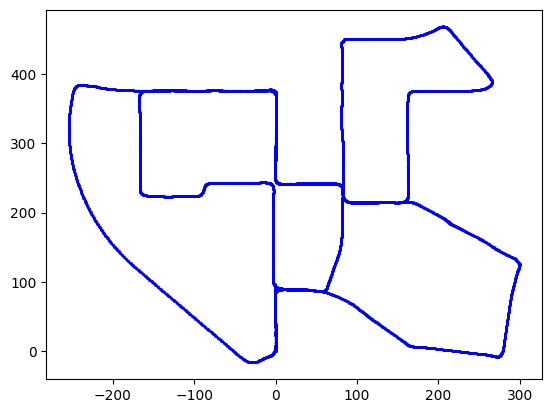

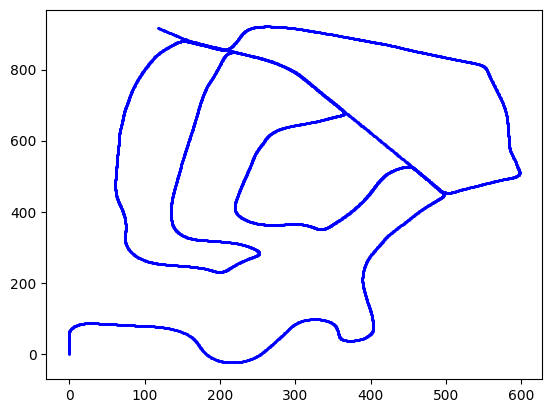

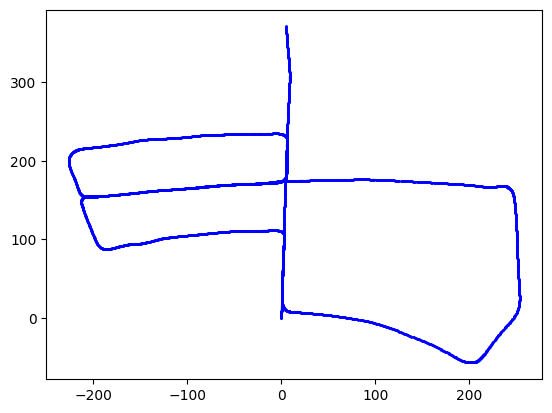

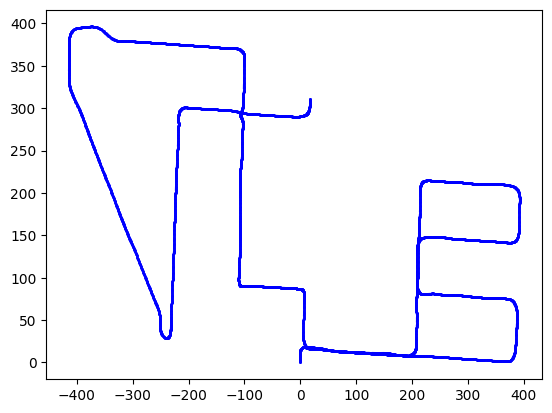

In [55]:
def z_align(pose_data):
    N = pose_data.shape[0]
    xyz = pose_data[:,0:3]
    # print(f"xys.shape: {xyz.shape}")
    pca = PCA(n_components=3)
    pca.fit(xyz)
    # print(pca.explained_variance_ratio_.shape)
    # print(pca.components_.shape, type(pca.components_))
    R = pca.components_
    # print(np.dot(R, R.T))
    # print("Align R.T:\n", R.T)
    new_xyz = np.dot(xyz, R.T)
    pca2 = PCA(n_components=3)
    pca2.fit(new_xyz)
    # print(pca2.components_)
    # print(pca2.explained_variance_)
    return new_xyz, R

def xy_align(translations: np.ndarray):
    i0 = 0
    i1 = 1
    while np.linalg.norm(translations[i0,:] - translations[i1,:]) < 1.0:
        i1 += 1
    print(translations[i0,:])
    print(translations[i1,:])
    theta = np.arctan2(translations[i1,0] - translations[i0,0],
                       translations[i1,1] - translations[i0,1])
    print(f"theta: {theta}")
    R = Rotation.from_euler('Z', theta)
    new_translations = R.apply(translations)
    return new_translations

def downsample_numpy(cloud: np.ndarray, voxel_size: float):
    voxel_indices = np.floor(cloud[:,:3] / voxel_size).astype(int)
    unique_voxel_indices, unique_indices = np.unique(voxel_indices, axis=0, return_index=True)
    downsampled_point_cloud = cloud[unique_indices]

    print(f"Original: {cloud.shape}")
    print(f"Downsampled: {downsampled_point_cloud.shape}")
    return downsampled_point_cloud


def process_kitti(root: Path, seq: str, t_thres: int, t_overl: int):
    seq_dir = root / seq
    output_dir = seq_dir / f'keyframes_per{t_thres}m_over{t_overl}m'
    keyfrmae_dat_fn = seq_dir / f'keyframes_dat_per{t_thres}m_over{t_overl}m.txt'
    keyfrmae_idx_fn = seq_dir / f'keyframes_idx_per{t_thres}m_over{t_overl}m.txt'
    pose_aligned_fn = seq_dir / 'pose_aligned.txt'

    t_thres = float(t_thres)
    t_overl = float(t_overl)

    # Load LiDAR scan_paths
    lidar_data_fn = seq_dir / 'lidar_data.txt'
    print(f"output_dir: {output_dir}")
    laser_timestamps = []
    scan_paths = []
    with open(lidar_data_fn, 'r') as f:
        lidar_data = f.readlines()
        for data in lidar_data:
            laser_timestamps.append(float(data.strip().split(' ')[0]))
            scan_paths.append(data.strip().split(' ')[1])
    laser_timestamps = np.array(laser_timestamps, dtype=float)
    print(f"laser_timestamps.length: {laser_timestamps.shape[0]}")
    print(f"scan_paths.length: {len(scan_paths)}")

    # Load poses
    pose = np.genfromtxt(seq_dir / 'pose.txt', dtype=float)
    timestamps = pose[:,0]
    translations = pose[:,1:4]
    quaternions = pose[:,4:]
    print(f"timestamps shape: {timestamps.shape}")
    print(f"translations shape: {translations.shape}")
    print(f"quaternions shape: {quaternions.shape}")
    translations = np.array(translations, dtype=float)

    translations, align_R = z_align(translations)
    translations = xy_align(translations)
    plot_xy_trajectory = True
    if plot_xy_trajectory:
        fig, axs = plt.subplots(1, 1)
        axs.plot(translations[:,0], translations[:,1],
                 color='b', marker='o',
                 linestyle='dashed', linewidth=1, markersize=1)
        axs.set_aspect('auto')
        # axs.set_xlim(translations[0,0], translations[-1,0])
        # axs.set_ylim(translations[0,1], translations[-1,1])
        fig.show()

        # plt.scatter(translations[:,2], translations[:,1])
        # plt.scatter(translations[:,0], translations[:,2])

    # Length check
    N_SCAN = laser_timestamps.shape[0]
    assert (N_SCAN == len(scan_paths))
    assert (N_SCAN == timestamps.shape[0])
    assert (N_SCAN == translations.shape[0])
    assert (N_SCAN == quaternions.shape[0])

    keyframe_indexs = []
    keyframe_data = [] # timestamp[ns],northing,easting
    prev_translation = translations[0,:]
    prev_index = 0
    pprev_translation = translations[0,:]
    pprev_index = 0
    for curr_index in range(1,N_SCAN):
        dist = np.linalg.norm(translations[curr_index,:] - prev_translation)
        if dist < t_thres or curr_index - prev_index < 1:
            continue
        else:
            if prev_index == pprev_index:
                prev_index = curr_index
                prev_translation = translations[curr_index,:]
                continue

            x_cen, y_cen, cnt = 0.0, 0.0, 0.0
            for i in range(pprev_index, curr_index):
                x_cen += translations[i,0]
                y_cen += translations[i,1]
                cnt += 1.0
            x_cen /= cnt
            y_cen /= cnt

            keyframe_indexs.append([pprev_index, curr_index-1])
            keyframe_data.append([
                int(laser_timestamps[curr_index]*1e9),
                x_cen, y_cen])
            # print(f"Add keyframe [{prev_index}, {curr_index-1}]")
            # print(f"Add keyframe [{keyframe_data[-1][0]},{keyframe_data[-1][1]:.2f},{keyframe_data[-1][2]:.2f}]")

            pprev_index = prev_index
            pprev_translation = translations[prev_index,:]
            prev_index = curr_index
            prev_translation = translations[curr_index,:]

    with open(keyfrmae_dat_fn, 'w') as f:
        for i in range(len(keyframe_data)):
            f.write(f"{keyframe_data[i][0]} {keyframe_data[i][1]:.6f} {keyframe_data[i][2]:.6f}\n")

    with open(keyfrmae_idx_fn, 'w') as f:
        for i in range(len(keyframe_indexs)):
            f.write(f"{keyframe_indexs[i][0]} {keyframe_indexs[i][1]}\n")

    with open(pose_aligned_fn, 'w') as f:
        for i in range(laser_timestamps.shape[0]):
            f.write(f"{laser_timestamps[i]:.6f} {translations[i,0]:.6f} {translations[i,1]:.6f} {translations[i,2]:.6f}")

for seq in SEQS:
    process_kitti(DATASET_DIR, seq, 5, 10)


In [29]:
def plot_bin(root: Path, index: int):
    scan_fn = root / f"{index:06d}.bin"
    path00 = scan_fn
    # Read the binary LiDAR data file
    scan00 = np.fromfile(path00, dtype=np.float32)
    scan00 = scan00.reshape((-1, 4))
    xyz = scan00[:, :3]
    print(f"1st scan: {path00}, n_pts: {scan00.shape[0]}")

    # Create an Open3D point cloud
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(xyz)
    o3d.visualization.draw_geometries([point_cloud],
                                    zoom=0.8,
                                    front=[-0.4999, -0.1659, -0.8499],
                                    lookat=[2.1813, 2.0619, 2.0999],
                                    up=[0.1204, -0.9852, 0.1215])


In [31]:
# process(DATASET_DIR, SEQS[0])
# R = Rotation.from_quat(quaternions[0])

plot_bin(Path("/data/datasets/dataset_project/hangpa00/lidar_undistorted"), 1)


1st scan: /data/datasets/dataset_project/hangpa00/lidar_undistorted/000001.bin, n_pts: 4333


In [ ]:
# import matplotlib.pyplot as plt
# plt.scatter(translations[:,1], translations[:,2])

# Center the data by subtracting the mean of each dimension
mean = np.mean(translations, axis=0)
centered_data = translations - mean

# Compute the covariance matrix
cov_matrix = np.cov(centered_data, rowvar=False)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
print(f"eigenvalues: {eigenvalues}")


In [ ]:
min_eigenvector = eigenvectors[2]
aim_eigenvector = np.array([0., 0., 1.], dtype=float)

# Step 1: Calculate the axis of rotation using the cross product
axis_of_rotation = np.cross(min_eigenvector, aim_eigenvector)
axis_of_rotation /= np.linalg.norm(axis_of_rotation)

# Step 2: Calculate the angle of rotation using the dot product
angle_of_rotation = np.arccos(np.dot(min_eigenvector, aim_eigenvector))

# Step 3: Create the rotation matrix using the axis-angle representation
c = np.cos(angle_of_rotation)
s = np.sin(angle_of_rotation)
t = 1 - c

rotation_matrix = np.array([[t * axis_of_rotation[0] ** 2 + c, t * axis_of_rotation[0] * axis_of_rotation[1] - s * axis_of_rotation[2], t * axis_of_rotation[0] * axis_of_rotation[2] + s * axis_of_rotation[1]],
                            [t * axis_of_rotation[0] * axis_of_rotation[1] + s * axis_of_rotation[2], t * axis_of_rotation[1] ** 2 + c, t * axis_of_rotation[1] * axis_of_rotation[2] - s * axis_of_rotation[0]],
                            [t * axis_of_rotation[0] * axis_of_rotation[2] - s * axis_of_rotation[1], t * axis_of_rotation[1] * axis_of_rotation[2] + s * axis_of_rotation[0], t * axis_of_rotation[2] ** 2 + c]])


In [ ]:
print(rotation_matrix)


In [ ]:
translations = np.array(translations, dtype=float)

def z_align(pose_data):
    N = pose_data.shape[0]
    xyz = pose_data[:,0:3]
    # print(f"xys.shape: {xyz.shape}")
    pca = PCA(n_components=3)
    pca.fit(xyz)
    # print(pca.explained_variance_ratio_.shape)
    # print(pca.components_.shape, type(pca.components_))
    R = pca.components_
    # print(np.dot(R, R.T))
    # print("Align R.T:\n", R.T)
    new_xyz = np.dot(xyz, R.T)
    pca2 = PCA(n_components=3)
    pca2.fit(new_xyz)
    # print(pca2.components_)
    # print(pca2.explained_variance_)
    return new_xyz

new_trs = z_align(translations)
print(new_trs.shape)
plt.scatter(new_trs[:,0], new_trs[:,1])
plt.scatter(new_trs[:,2], new_trs[:,1])
plt.scatter(new_trs[:,0], new_trs[:,2])


In [ ]:

print(eigenvalues)
# The eigenvectors are the principal components

# Optionally, you can choose the number of principal components to keep
n_components = 2
principal_components = eigenvectors[:, :n_components]

# Project the data onto the principal components
projected_data = np.dot(centered_data, principal_components)

print("Principal Components (Eigenvectors):")
print(principal_components)

print("Projected Data:")
print(projected_data)


In [ ]:
# Parameters
to_display=1
start_chunk=1
target_pc_size=4096

#submap generation
submap_cover_distance=20.0
laser_reading_distance=0.025
laser_reading_angle=30
dist_start_next_frame=10.0


In [ ]:
# Set up CSV file
csv_file_name = DATASET_DIR / 'test.csv'
fid_locations = open(csv_file_name, 'w')
fid_locations.write('# timestamp,northing,easting\n')


In [ ]:

for chunk = start_chunk:laser_timestamps(end,2)
    # find readings in chunk
    laser_index_start= find(laser_timestamps(:,2) == chunk, 1, 'first');
    laser_index_end= find(laser_timestamps(:,2) == chunk, 1, 'last');

    l_timestamps = laser_timestamps(laser_index_start:laser_index_end,1);

    disp(strcat('Processing chunk: ',num2str(chunk),' Laser Start Index: ',num2str(laser_index_start),' Laser End Index: ',num2str(laser_index_end)));
    # filter edge cases
    if (chunk==1)
        # remove first few readings (in car park)
        l_timestamps=laser_timestamps(laser_index_start+5000:laser_index_end,1);
    end

    if (chunk==laser_timestamps(end,2))
        %remove last readings
        l_timestamps=laser_timestamps(laser_index_start:laser_index_end-1000,1);
    end

    # POSES%%%%%%%%%%
    laser_global_poses = getGlobalPoses(strcat(base_path,'/gps/ins.csv'), l_timestamps');
    disp(strcat('Processing chunk: ',num2str(chunk),' Loaded laser poses'));


    # Counter Variables%%%%
    # laser
    frame_start=1;
    frame_end=frame_start+1;
    frames=[];
    i=frame_start;
    j=i;
    start_next_frame=frame_start;
    got_next=0;


    while frame_end < length(l_timestamps):
        # GET SCANS TO GENERATE SUBMAP
        while(getDistance(laser_global_poses{i}(1,4),           laser_global_poses{i}(2,4),
                          laser_global_poses{frame_start}(1,4), laser_global_poses{frame_start}(2,4)) < submap_cover_distance)
            if(j>(length(l_timestamps)-1))
                break
            end
            j=j+1;

            while((getDistance(laser_global_poses{i}(1,4), laser_global_poses{i}(2,4),
                               laser_global_poses{j}(1,4), laser_global_poses{j}(2,4)) < laser_reading_distance)...
                    && (getRotation(laser_global_poses{i}(1:3,1:3), laser_global_poses{j}(1:3,1:3))*180/pi <laser_reading_angle))
                j=j+1;
                if(j>(length(l_timestamps)-1))
                    break
                end
            end
            frames=[frames j];

            if(j>(length(l_timestamps)-1))
                break
            end

            if(getDistance(laser_global_poses{frame_start}(1,4), laser_global_poses{frame_start}(2,4),
                           laser_global_poses{j}(1,4),           laser_global_poses{j}(2,4))>dist_start_next_frame && got_next==0)
              start_next_frame=frames(1,end);
              got_next=1;
            end
        i=j;
        end

        if(j>length(l_timestamps)-1)
            break
        end
        frame_end=j;
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        %%%%%%%Build Pointcloud%%%%%%%
        pointcloud = [];
        for i=frames
            scan_path = [laser_dir num2str(l_timestamps(i,1)) '.bin'];
            scan_file = fopen(scan_path);
            scan = fread(scan_file, 'double');
            fclose(scan_file);

            scan = reshape(scan, [3 numel(scan)/3]);
            scan(3,:) = zeros(1, size(scan,2));

            scan = inv(laser_global_poses{frame_start})*laser_global_poses{i} * G_ins_laser * [scan; ones(1, size(scan,2))];
            pointcloud = [pointcloud scan(1:3,:)];
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        %%%Remove ground plane
        [normal, in_plane, out_plane]=pcfitplane(pointCloud(pointcloud'),0.5);

        %%%%%%%%%%%Check if not enough points after road removal
        if (size(out_plane,1)<target_pc_size)
            %reset variables
            if (got_next==0)
                frame_start=frame_start+50;
                start_next_frame=frame_start+7;
            else
                frame_start=start_next_frame;
                start_next_frame=frame_start;
            end
            frame_end= frame_start+1;
            frames=[frame_start];
            i=frame_start;
            j=i;
            got_next=0;

            disp('Faulty pointcloud');
            continue
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        %%%%%%%%Downsample to exactly target_pc_size points%%%%%%%%%%%%
        out_of_plane=pointcloud(:,out_plane);

        %find appropriate scale
        scale_size=1.001;
        downsampled=pcdownsample(pointCloud(out_of_plane'),'gridAverage',scale_size);

        while (downsampled.Count()<target_pc_size)
            scale_size=scale_size-0.025;
            if(scale_size<=0)
                xyz=out_of_plane';
                break;
            end
            downsampled=pcdownsample(pointCloud(out_of_plane'),'gridAverage',scale_size);
        end

        while (downsampled.Count()>target_pc_size)
            scale_size=scale_size+0.025;
            downsampled=pcdownsample(pointCloud(out_of_plane'),'gridAverage',scale_size);
        end

        if(scale_size>0)
            xyz=[downsampled.Location(:,1),downsampled.Location(:,2),downsampled.Location(:,3)];
        end

        %add additional random points
        num_extra_points=target_pc_size-size(xyz,1);
        permutation=randperm(length(out_of_plane));
        sample_out=permutation(1:num_extra_points);
        sample=out_of_plane(:,sample_out);%3xn

        output=[xyz',sample];
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        %%%%%%%%%%%%%%%%%Transform pointcloud%%%%%%%%%%%%%%%%%%%%%%%%%%
        %transform wrt the centroid
        x_cen=mean(output(1,:));
        y_cen=mean(output(2,:));
        z_cen=mean(output(3,:));
        centroid=[x_cen;y_cen;z_cen;1];
        centroid_g=double(laser_global_poses{frame_start})*double(centroid);

        %make spread s=0.5/d
        sum=0;
        for i=1:size(output,2)
            sum=sum+sqrt((output(1,i)-x_cen)^2+(output(2,i)-y_cen)^2+(output(3,i)-z_cen)^2);
        end
        d=sum/size(output,2);
        s=0.5/d;

        T=[[s,0,0,-s*(x_cen)];...
        [0,s,0,-s*(y_cen)];...
        [0,0,s,-s*(z_cen)];...
        [0,0,0,1]];
        scaled_output=T*[output; ones(1, size(output,2))];
        scaled_output=-scaled_output;

        %Enforce to be in [-1,1] and have exactly target_pc_size points
        cleaned=[];
        for i=1:size(scaled_output,2)
            if(scaled_output(1,i)>=-1 && scaled_output(1,i)<=1 && scaled_output(2,i)>=-1 && scaled_output(2,i)<=1 ...
                    && scaled_output(3,i)>=-1 && scaled_output(3,i)<=1)
                cleaned=[cleaned,scaled_output(:,i)];
            end
        end

        %make number of points equal to target_pc_size
        num_extra_points=target_pc_size-size(cleaned,2);
        disp(strcat(num2str(size(cleaned,2)),'.',num2str(num_extra_points)));
        permutation=randperm(length(out_of_plane));
        i=1;
        while size(cleaned,2)<target_pc_size
            new_point=-T*[out_of_plane(:,permutation(1,i));1];
            if(new_point(1,1)>=-1 && new_point(1,1)<=1 && new_point(2,1)>=-1 && new_point(2,1)<=1 ...
                    && new_point(3,1)>=-1 && new_point(3,1)<=1)
                cleaned=[cleaned,new_point];
            end
            i=i+1;
        end
        cleaned=cleaned(1:3,:);
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        %%%Double check
        if(size(cleaned,2)~=target_pc_size)
            frame_start=start_next_frame;
            frame_end= frame_start+1;
            frames=[frame_start];
            i=frame_start;
            j=i;
            disp('Invalid pointcloud')
            continue;
        end

        %%%Output Files
        %output pointcloud in binary file
        origin_timestamp=l_timestamps(frames(1,1),1);
        fileID = fopen(strcat(base_path,pc_output_folder, num2str(origin_timestamp),'.bin'),'w');
        fwrite(fileID,cleaned,'double');
        fclose(fileID);
        disp(num2str(origin_timestamp));

        %write line in csv file
        fprintf(fid_locations, '%s,%f,%f\n',num2str(origin_timestamp),centroid_g(1,1), centroid_g(2,1));

        %%%Display
        if(to_display)
            figure(1);
            pcshow(cleaned');
            axis equal;
            pause
        end

        # Reset Variables%%%%%%
        if (got_next==0)
            frame_start=frame_start+50;
        else
            frame_start=start_next_frame;
        end
        frame_end= frame_start+1
        frames=[frame_start]
        i=frame_start
        j=i
        got_next=0
    end
end
fclose(fid_locations);


## Origin MATLAB Code (In PointNetVLAD)

In [ ]:
# function generate_submaps(base_path)
#     %To Use: generate_submaps('/media/deep-three/deep_ssd2/Robotcar/2014-05-19-13-05-38')

#     %%%%%%%%%%%%Folder Locations%%%%%%%%
#     %lidar
#     base_path= strcat(base_path, '/');
#     laser='lms_front';
#     laser_dir= strcat(base_path,laser,'/');
#     pc_output_folder='pointclouds/';

#     %make pc output folder
#     mkdir(strcat(base_path,pc_output_folder));
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#     %%%%%%%%%%%%%%%Load extrinsics%%%%%%%%
#     extrinsics_dir='/home/vgd/Documents/robotcar-dataset-sdk-2.1/extrinsics/';
#     laser_extrinisics = dlmread([extrinsics_dir 'lms_front.txt']);
#     ins_extrinsics = dlmread([extrinsics_dir 'ins.txt']);

#     G_ins_laser = SE3MatrixFromComponents(ins_extrinsics) \ SE3MatrixFromComponents(laser_extrinisics);
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#     %%%%%%%%%%%%%%%Timestamps%%%%%%%%%%%%%
#     laser_timestamps = dlmread(strcat(base_path,'/',laser,'.timestamps'));
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#     %%%%%%%%%%%%Parameters%%%%%%%%%%%%%%%
#     to_display=1;

#     start_chunk=1;
#     target_pc_size=4096;

#     %submap generation
#     submap_cover_distance=20.0;
#     laser_reading_distance=0.025;
#     laser_reading_angle=30;
#     dist_start_next_frame=10.0;
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#     %%%%%%%%%%Set up CSV file%%%%%%%%%%%%
#     csv_file_name= 'test.csv';
#     fid_locations=fopen(strcat(base_path,csv_file_name), 'w');
#     fprintf(fid_locations,'%s,%s,%s\n','timestamp','northing','easting');
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#     for chunk = start_chunk:laser_timestamps(end,2)
#         %find readings in chunk
#         laser_index_start= find(laser_timestamps(:,2) == chunk, 1, 'first');
#         laser_index_end= find(laser_timestamps(:,2) == chunk, 1, 'last');

#         l_timestamps=laser_timestamps(laser_index_start:laser_index_end,1);

#         disp(strcat('Processing chunk: ',num2str(chunk),' Laser Start Index: ',num2str(laser_index_start),' Laser End Index: ',num2str(laser_index_end)));
#         %filter edge cases
#         if (chunk==1)
#            %remove first few readings (in car park)
#            l_timestamps=laser_timestamps(laser_index_start+5000:laser_index_end,1);
#         end

#         if (chunk==laser_timestamps(end,2))
#            %remove last readings
#            l_timestamps=laser_timestamps(laser_index_start:laser_index_end-1000,1);
#         end

#         %%%%%%%%%%POSES%%%%%%%%%%
#         laser_global_poses=getGlobalPoses(strcat(base_path,'/gps/ins.csv'), l_timestamps');
#         disp(strcat('Processing chunk: ',num2str(chunk),' Loaded laser poses'));
#         %%%%%%%%%%%%%%%%%%%%%%%%%

#         %%%%Counter Variables%%%%
#         %laser
#         frame_start=1;
#         frame_end=frame_start+1;
#         frames=[];
#         i=frame_start;
#         j=i;
#         start_next_frame=frame_start;
#         got_next=0;
#         %%%%%%%%%%%%%%%%%%%%%%%%%%

#         while(frame_end<length(l_timestamps))
#             %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%GET SCANS TO GENERATE SUBMAP%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#             while(getDistance(laser_global_poses{i}(1,4), laser_global_poses{i}(2,4),laser_global_poses{frame_start}(1,4), laser_global_poses{frame_start}(2,4))<submap_cover_distance)
#                 if(j>(length(l_timestamps)-1))
#                    break
#                 end
#                 j=j+1;

#                 while((getDistance(laser_global_poses{i}(1,4), laser_global_poses{i}(2,4), laser_global_poses{j}(1,4), laser_global_poses{j}(2,4))<laser_reading_distance)...
#                        && (getRotation(laser_global_poses{i}(1:3,1:3), laser_global_poses{j}(1:3,1:3))*180/pi <laser_reading_angle))
#                     j=j+1;
#                     if(j>(length(l_timestamps)-1))
#                         break
#                     end
#                 end
#                 frames=[frames j];

#                 if(j>(length(l_timestamps)-1))
#                     break
#                 end

#                 if(getDistance(laser_global_poses{frame_start}(1,4), laser_global_poses{frame_start}(2,4), laser_global_poses{j}(1,4), laser_global_poses{j}(2,4))>dist_start_next_frame && got_next==0)
#                   start_next_frame=frames(1,end);
#                   got_next=1;
#                 end
#             i=j;
#             end

#             if(j>length(l_timestamps)-1)
#                 break
#             end
#             frame_end=j;
#             %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#             %%%%%%%Build Pointcloud%%%%%%%
#             pointcloud = [];
#             for i=frames
#                 scan_path = [laser_dir num2str(l_timestamps(i,1)) '.bin'];
#                 scan_file = fopen(scan_path);
#                 scan = fread(scan_file, 'double');
#                 fclose(scan_file);

#                 scan = reshape(scan, [3 numel(scan)/3]);
#                 scan(3,:) = zeros(1, size(scan,2));

#                 scan = inv(laser_global_poses{frame_start})*laser_global_poses{i} * G_ins_laser * [scan; ones(1, size(scan,2))];
#                 pointcloud = [pointcloud scan(1:3,:)];
#             end
#             %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#             %%%Remove ground plane
#             [normal, in_plane, out_plane]=pcfitplane(pointCloud(pointcloud'),0.5);

#             %%%%%%%%%%%Check if not enough points after road removal
#             if (size(out_plane,1)<target_pc_size)
#                 %reset variables
#                 if (got_next==0)
#                    frame_start=frame_start+50;
#                    start_next_frame=frame_start+7;
#                 else
#                    frame_start=start_next_frame;
#                    start_next_frame=frame_start;
#                 end
#                 frame_end= frame_start+1;
#                 frames=[frame_start];
#                 i=frame_start;
#                 j=i;
#                 got_next=0;

#                 disp('Faulty pointcloud');
#                 continue
#             end
#             %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#             %%%%%%%%Downsample to exactly target_pc_size points%%%%%%%%%%%%
#             out_of_plane=pointcloud(:,out_plane);

#             %find appropriate scale
#             scale_size=1.001;
#             downsampled=pcdownsample(pointCloud(out_of_plane'),'gridAverage',scale_size);

#             while (downsampled.Count()<target_pc_size)
#                scale_size=scale_size-0.025;
#                if(scale_size<=0)
#                     xyz=out_of_plane';
#                     break;
#                end
#                downsampled=pcdownsample(pointCloud(out_of_plane'),'gridAverage',scale_size);
#             end

#             while (downsampled.Count()>target_pc_size)
#                scale_size=scale_size+0.025;
#                downsampled=pcdownsample(pointCloud(out_of_plane'),'gridAverage',scale_size);
#             end

#             if(scale_size>0)
#                 xyz=[downsampled.Location(:,1),downsampled.Location(:,2),downsampled.Location(:,3)];
#             end

#             %add additional random points
#             num_extra_points=target_pc_size-size(xyz,1);
#             permutation=randperm(length(out_of_plane));
#             sample_out=permutation(1:num_extra_points);
#             sample=out_of_plane(:,sample_out);%3xn

#             output=[xyz',sample];
#             %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#             %%%%%%%%%%%%%%%%%Transform pointcloud%%%%%%%%%%%%%%%%%%%%%%%%%%
#             %transform wrt the centroid
#             x_cen=mean(output(1,:));
#             y_cen=mean(output(2,:));
#             z_cen=mean(output(3,:));
#             centroid=[x_cen;y_cen;z_cen;1];
#             centroid_g=double(laser_global_poses{frame_start})*double(centroid);

#             %make spread s=0.5/d
#             sum=0;
#             for i=1:size(output,2)
#                 sum=sum+sqrt((output(1,i)-x_cen)^2+(output(2,i)-y_cen)^2+(output(3,i)-z_cen)^2);
#             end
#             d=sum/size(output,2);
#             s=0.5/d;

#             T=[[s,0,0,-s*(x_cen)];...
#             [0,s,0,-s*(y_cen)];...
#             [0,0,s,-s*(z_cen)];...
#             [0,0,0,1]];
#             scaled_output=T*[output; ones(1, size(output,2))];
#             scaled_output=-scaled_output;

#             %Enforce to be in [-1,1] and have exactly target_pc_size points
#             cleaned=[];
#             for i=1:size(scaled_output,2)
#                if(scaled_output(1,i)>=-1 && scaled_output(1,i)<=1 && scaled_output(2,i)>=-1 && scaled_output(2,i)<=1 ...
#                        && scaled_output(3,i)>=-1 && scaled_output(3,i)<=1)
#                     cleaned=[cleaned,scaled_output(:,i)];
#                end
#             end

#             %make number of points equal to target_pc_size
#             num_extra_points=target_pc_size-size(cleaned,2);
#             disp(strcat(num2str(size(cleaned,2)),'.',num2str(num_extra_points)));
#             permutation=randperm(length(out_of_plane));
#             i=1;
#             while size(cleaned,2)<target_pc_size
#                new_point=-T*[out_of_plane(:,permutation(1,i));1];
#                if(new_point(1,1)>=-1 && new_point(1,1)<=1 && new_point(2,1)>=-1 && new_point(2,1)<=1 ...
#                        && new_point(3,1)>=-1 && new_point(3,1)<=1)
#                     cleaned=[cleaned,new_point];
#                end
#                i=i+1;
#             end
#             cleaned=cleaned(1:3,:);
#             %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#             %%%Double check
#             if(size(cleaned,2)~=target_pc_size)
#                frame_start=start_next_frame;
#                frame_end= frame_start+1;
#                frames=[frame_start];
#                i=frame_start;
#                j=i;
#                disp('Invalid pointcloud')
#                continue;
#             end

#             %%%Output Files
#             %output pointcloud in binary file
#             origin_timestamp=l_timestamps(frames(1,1),1);
#             fileID = fopen(strcat(base_path,pc_output_folder, num2str(origin_timestamp),'.bin'),'w');
#             fwrite(fileID,cleaned,'double');
#             fclose(fileID);
#             disp(num2str(origin_timestamp));

#             %write line in csv file
#             fprintf(fid_locations, '%s,%f,%f\n',num2str(origin_timestamp),centroid_g(1,1), centroid_g(2,1));

#             %%%Display
#             if(to_display)
#                 figure(1);
#                 pcshow(cleaned');
#                 axis equal;
#                 pause
#             end

#             %%%%%%%Reset Variables%%%%%%
#             if (got_next==0)
#                frame_start=frame_start+50;
#             else
#                frame_start=start_next_frame;
#             end
#             frame_end= frame_start+1;
#             frames=[frame_start];
#             i=frame_start;
#             j=i;
#             got_next=0;
#             %%%%%%%%%%%%%%%%%%%%%%%%%%%%
#         end
#     end
#     fclose(fid_locations);
#     plot_pointcloud_path(base_path);
# end


In [26]:
import os
from pathlib import Path
import numpy as np

pose_dir = Path('/data/datasets/dataset_kitti/dataset/poses')
fns = os.listdir(pose_dir)
fns.sort()

for fn in fns:
    if not '.txt' in fn:
        continue

    print(pose_dir / fn)
    full_fn = pose_dir / fn
    # print(fn.split('.')[0])
    data = np.genfromtxt(full_fn)

    # new_fn = pose_dir / (fn.split('.')[0]+'.csv')
    new_fn = Path('/data/datasets/dataset_kitti') / fn.split('.')[0] / f"{fn.split('.')[0]}.csv"
    print(new_fn)
    np.savetxt(new_fn, data, delimiter=',')


/data/datasets/dataset_kitti/dataset/poses/00.txt
/data/datasets/dataset_kitti/00/00.csv
/data/datasets/dataset_kitti/dataset/poses/01.txt
/data/datasets/dataset_kitti/01/01.csv
/data/datasets/dataset_kitti/dataset/poses/02.txt
/data/datasets/dataset_kitti/02/02.csv
/data/datasets/dataset_kitti/dataset/poses/03.txt
/data/datasets/dataset_kitti/03/03.csv
/data/datasets/dataset_kitti/dataset/poses/04.txt
/data/datasets/dataset_kitti/04/04.csv
/data/datasets/dataset_kitti/dataset/poses/05.txt
/data/datasets/dataset_kitti/05/05.csv
/data/datasets/dataset_kitti/dataset/poses/06.txt
/data/datasets/dataset_kitti/06/06.csv
/data/datasets/dataset_kitti/dataset/poses/07.txt
/data/datasets/dataset_kitti/07/07.csv
/data/datasets/dataset_kitti/dataset/poses/08.txt
/data/datasets/dataset_kitti/08/08.csv
/data/datasets/dataset_kitti/dataset/poses/09.txt
/data/datasets/dataset_kitti/09/09.csv
/data/datasets/dataset_kitti/dataset/poses/10.txt
/data/datasets/dataset_kitti/10/10.csv
